# Model
1. Preprocess (Otake or Tamura method)
2. Feature Extraction (R1, SR)
3. Machine Learning

Machine Learning Model
- Random Forest(RF)
- Gradient Tree Boosting(GTB)
- Ridge Regressor(RR)
- Supprot Vector Machine(SVM)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from collections import namedtuple
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [3]:
# @title Original function
def pooling(df,spl = 10): # 列方向に平均化
  col = np.arange(int(df.shape[1]/spl))*spl
  pool_val = [];col_ = []
  for i in range(len(col[:-1])):
    pool_val.append(df.values[:, col[i]:col[i+1]].mean(1))
    col_.append(np.mean(df.columns[col[i]:col[i+1]].astype('float64')))
  pool_val.append(df.values[:, col[-1]:].mean(1))
  col_.append(np.mean(df.columns[col[-1]:].astype('float64')))
  return pd.DataFrame(np.array(pool_val).T,columns = col_,index = df.index)

def train_(X,y,model,cv = 10,label = 'aBMD $[g/cm^2]$'):
  res_pred = np.zeros_like(y);r2_add=[]
  cv = KFold(n_splits=cv, shuffle=True, random_state=1234)
  for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    res_pred[test_index] = pred
    print('r2 = ', metrics.r2_score(y_test,pred))
    r2_add.append(metrics.r2_score(y_test,pred))
  print('All r2 = ', metrics.r2_score(y,res_pred))
  print('Mean r2 = ', round(np.mean(r2_add),5),'±', round(np.std(r2_add),5))
  showGraph(y,res_pred,label = label,dpi=100)
  return res_pred, metrics.r2_score(y,res_pred)

def showGraph(y,res_pred,label = 'aBMD $[g/cm^2]$',dpi=100,figsize =(4,4)):
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot(y,res_pred,'.' ,c = 'k')
  correlationLine(y,res_pred,score = 'r2')
  plt.legend(edgecolor='none')
  plt.xlabel('Reference '+label)
  plt.ylabel('Predicted '+label)
  plt.show()
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot((y+res_pred)/2,y-res_pred,'.' ,c = 'k')
  max_ = max((y+res_pred)/2)
  min_ = min((y+res_pred)/2)
  mean_ = np.mean(y-res_pred)
  upp_ = mean_+1.96*np.std(y-res_pred)
  low_ = mean_-1.96*np.std(y-res_pred)
  plt.plot([min_,max_],[mean_,mean_],':',c = 'k')
  plt.plot([min_,max_],[upp_,upp_],'-.',c = 'k')
  plt.plot([min_,max_],[low_,low_],'-.',c = 'k')
  correlationLine((y+res_pred)/2,y-res_pred)
  plt.legend(edgecolor='none')
  label_ = 'Mean of predicted and reference '+label
  plt.xlabel(label_)
  label_ = 'Difference between \n predicted and reference '+label
  plt.ylabel(label_)
  plt.show()
  print('loa_upper: ',round(upp_,5))
  print('loa_lower: ',round(low_,5))
  print("Mean: ",mean_)

def correlationLine(x,y,score = 'r'):
  x = np.array(x).flatten()
  y = np.array(y).flatten()
  #相関
  if score =='r':
    slope, intercept, r_value, _, _ = stats.linregress(x,y)
    r, p = stats.pearsonr(x,y)
    print(stats.spearmanr(x,y))
    label_ = "r = "+str(round(r_value,3))
  if score == 'r2':
    r_value = metrics.r2_score(x,y)
    label_ = "$r^2$ = "+str(round(r_value,3))
    print('pearsonr:',stats.pearsonr(x,y))
  ysub = np.poly1d(np.polyfit(x,y,1))(x)
  xx = [x.min(),x.max()]
  yy = [ysub.min(),ysub.max()]
  if r_value < 0:
    yy = [ysub.max(),ysub.min()]
  plt.plot(xx,yy,"--",color="0.2",label = label_)

In [4]:
version = "ellipse"
path = f"/content/drive/MyDrive/Tamura/ML/{version}/dataset/"

files = glob.glob(f"{path}opt_result/*.csv")
sim_params = pd.read_csv(f"{path}params.csv", index_col=0)
len(files)

1261

In [5]:
def process(df, window, spl, step):
  df_1 = df.rolling(window, axis=1).mean().dropna(axis=1)
  df_2 = pooling(df_1, spl=spl)
  df_3 = df_2[::step]
  data = np.log(df_3.values + 1).flatten()
  return data

In [70]:
nn = 1211
spl = 25; window = 20; step = 3
#spl=25; window=20; step=3 # Otake parameter
#spl=25; window=20; step=1 # Tamura parameter

dataset = pd.DataFrame()
for i in tqdm(range(nn)):
  df = pd.read_csv(files[i], index_col=0).fillna(0)
  data = process(df, window, spl, step)

  filename = files[i].split('/')[-1].split('.')[0]
  target = sim_params[sim_params["filename"]==filename]["aBMD"]
  subset = pd.Series(np.append(data, target), name=filename, index=[f"var{i}" for i in range(data.size)]+["target"])
  dataset = pd.concat([dataset, subset.to_frame().T])
dataset.head()

100%|██████████| 1211/1211 [00:53<00:00, 22.74it/s]


,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,var212,var213,var214,var215,var216,var217,var218,var219,var220,target
2023-10-20T23-22-02_it0011,1.808740e-10,1.992295e-09,5.364458e-09,5.257858e-08,5.601098e-07,0.000007,0.000041,0.000027,0.000003,3.122404e-07,...,8.047750e-07,0.000007,0.000110,0.000035,0.000003,4.668000e-07,1.487503e-07,1.855913e-08,2.292308e-09,1.096468
2023-10-23T16-48-33_it0063,1.200021e-09,8.147397e-09,1.659211e-08,1.515353e-07,1.135506e-06,0.000012,0.000062,0.000040,0.000006,7.476691e-07,...,1.553650e-06,0.000011,0.000159,0.000052,0.000005,1.044544e-06,3.265943e-07,5.785917e-08,9.823487e-09,0.981377
2023-10-20T23-59-26_it0012,5.372724e-11,6.845204e-10,3.342389e-09,3.073142e-08,3.181402e-07,0.000004,0.000026,0.000016,0.000002,1.788071e-07,...,4.088415e-07,0.000004,0.000073,0.000024,0.000002,2.588972e-07,7.441555e-08,9.388162e-09,5.607423e-10,1.043875
2023-10-21T00-40-23_it0013,2.218548e-09,1.297812e-08,2.806134e-08,1.951429e-07,1.391855e-06,0.000014,0.000074,0.000048,0.000006,8.371023e-07,...,1.917078e-06,0.000013,0.000181,0.000060,0.000006,1.220432e-06,4.335634e-07,5.303320e-08,8.761537e-09,0.732898
2023-10-23T17-02-08_it0045,5.881129e-10,3.425092e-09,8.040996e-09,7.753927e-08,6.214238e-07,0.000006,0.000035,0.000022,0.000003,3.716734e-07,...,8.279034e-07,0.000006,0.000099,0.000033,0.000003,5.203724e-07,1.720644e-07,2.709986e-08,3.063021e-09,0.977665


In [72]:
features = dataset.drop('target',axis=1).columns
X = dataset[features].values
X = (X - X.mean(0)) / X.std(0)
y = dataset.target.values

In [75]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
# @title Random Forest
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RF",
        RandomForestRegressor(),
      {"n_estimators": [10, 20, 50, 100, 300],
       "max_features": ["log2", "sqrt", 1.0],
       "max_depth": [10, 20, 30, 40, 50],
       "n_jobs": [-1],
       })

In [76]:
# @title Gradient Tree Boosting
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("GTB",
        GradientBoostingRegressor(),
        {"n_estimators": [10, 20, 50, 100, 300],
         "max_features": ["log2", "sqrt", 1.0],
         "max_depth": [1, 2, 3, 4, 5],
         "learning_rate": [0.001, 0.01, 0.1, 1.0, 10],
         })

In [62]:
# @title Support Vector Machine
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("SVM",
        SVR(),
       {"kernel": ["rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
        })

In [66]:
# @title Ridge Regressor
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RR",
        Ridge(),
       {"alpha": [0.001, 0.01, 0.1, 1.0, 10],
        "fit_intercept": [True, False]
        })

In [77]:
grid_search = GridSearchCV(ml.model, ml.params, cv=10, n_jobs=-1, scoring='r2')
grid_search.fit(X_train_val, y_train_val)
print(f"Model: {ml.model}")
print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
print(f"Test score: {grid_search.score(X_test, y_test)}")

Model: GradientBoostingRegressor()
Best params: {'learning_rate': 0.1, 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 20}
Best score: 0.005244285638862445
Test score: -0.011094120360658266


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-6.75392957e-003 -6.65688993e-003 -6.33619293e-003 -5.75428776e-003
 -4.00043119e-003 -6.78352625e-003 -6.67585621e-003 -6.31743963e-003
 -5.83842180e-003 -3.89965216e-003 -6.63477863e-003 -6.37012311e-003
 -5.60844328e-003 -4.44024902e-003 -8.19173325e-004 -6.75304577e-003
 -6.46522351e-003 -5.94028585e-003 -4.97801962e-003 -1.77958311e-003
 -6.66194591e-003 -6.50764489e-003 -5.96042780e-003 -4.94367951e-003
 -1.72254673e-003 -6.56782114e-003 -6.24487249e-003 -5.33103986e-003
 -3.86968793e-003  2.63972676e-004 -6.68440105e-003 -6.52437425e-003
 -5.85108107e-003 -5.14060558e-003 -1.83733074e-003 -6.70776831e-003
 -6.44245759e-003 -5.82335713e-003 -4.85623556e-003 -1.52927739e-003
 -6.62203711e-003 -6.34835115e-003 -5.54452506e-003 -4.25818756e-003
 -3.88274927e-004 -6.70582871e-003 -6.46072267e-003 -5.89847918e-003
 -4.99867981e-003 -2.83853041e-0

In [78]:
result = {}

r2 =  -0.05030157999845786
r2 =  0.029299340539177043
r2 =  0.0001476024625184369
r2 =  -0.011530301091164707
r2 =  0.007860921240057328
r2 =  -0.012853601931964498
r2 =  -0.000502834491246551
r2 =  -0.017688190807365167
r2 =  0.004595839914027788
r2 =  0.005242382849977023
All r2 =  0.0019714648887613206
Mean r2 =  -0.00457 ± 0.01975
pearsonr: PearsonRResult(statistic=0.06177318633693731, pvalue=0.03159443426353542)


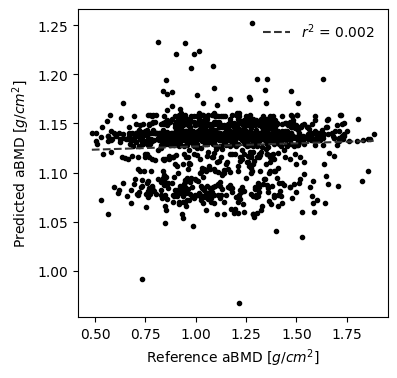

SignificanceResult(statistic=0.9767703600177599, pvalue=0.0)


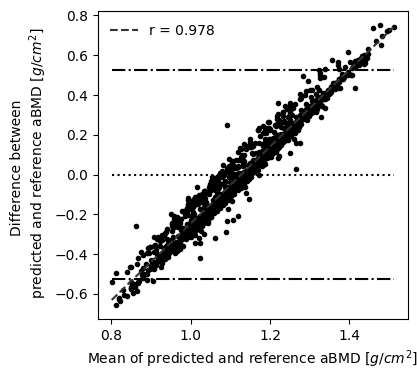

loa_upper:  0.52614
loa_lower:  -0.52645
Mean:  -0.00015492861920468363


In [79]:
ml.model.set_params(**grid_search.best_params_)
pred_, r2 = train_(X, y, ml.model, cv=10, label="aBMD $[g/cm^2]$")
result[ml.name] = r2

In [80]:
df = pd.DataFrame(result, index=['r2'])
df

,GTB
r2,0.001971


In [ ]:
path = f"/content/drive/MyDrive/Tamura/ML/{version}/result/"

f_num = len(glob.glob(f"{path}*.csv"))
df.to_csv(f"{path}result{f_num + 1}.csv")

# Memo
- Couldnt get high determination coefficient if i use Otake preprocessing to tamura dicom model. (r2=0.53:svm)

- reducing data in direction of bone axis doesnt work. No reduction is better. (reduce v no reduction = 0.53 v 0.60 : svm) It means the change in bone geometry in the direction of bone axis may have contributed to increase accuracy. Or the fact that the thickness of the soft tissue (dermis, subcutaneous tissue) does not change may contribute to improved accuracy.

- In the circumferential direction, the accuracy was very poor when all 360 degrees of data were input. (r2=0.04). Therefore, applying a pooling process in the circumferential direction would be effective. Moving averages are effective as well. As the light intensities in the circumferential direction are highly interrelated, if the data is not reduced, over-learning may occur and the accuracy may be low.